# Import packages

In [5]:
####import packages
using FFTW
using Distributions
#using NBInclude
#using Plots
using PyCall
using PyPlot
#using WebIO
using Pkg
using Interpolations
using LinearAlgebra
using Profile
using TensorOperations
import NaNMath
using DelimitedFiles
using Hilbert
using Wavelets
using Einsum

#get to the root of the project to ease path later on
if pwd()[end-7:end] == "Analysis"
    cd("..")
end

###import local files (CAUTION: kernel must be restarted if changes are made)
include("src/Coupling.jl") 
include("src/CouplingOptimization.jl")
include("src/Phase.jl") 
include("src/PhaseSim.jl") 
include("src/URTS.jl") 
include("src/HMM.jl") 
include("src/SignalAnalysis.jl") 
include("src/Plots.jl") 

#@nbinclude("Types.ipynb")

###set nice plotting style
@pyimport matplotlib.pyplot as p
p.style[:use]("seaborn-whitegrid")



┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1192
ERROR: LoadError: No deps.jl file could be found. Please try running Pkg.build("Arpack").
Currently, the build command might fail when Julia has been built from source
and the recommendation is to use the official binaries from julialang.org.
For more info see https://github.com/JuliaLinearAlgebra/Arpack.jl/issues/5.

Stacktrace:
 [1] top-level scope at /Users/cdroin/.juliapro/JuliaPro_v1.0.5-2/packages/Arpack/zCmTA/src/Arpack.jl:19
 [2] include_relative(::Module, ::String) at /Applications/JuliaPro-1.0.5-2.app/Contents/Resources/julia/Contents/Resources/julia/lib/julia/sys.dylib:?
 [3] include(::Module, ::String) at /Applications/JuliaPro-1.0.5-2.app/Contents/Resources/julia/Contents/Resources/julia/lib/julia/sys.dylib:?
 [4] top-level scope at none:2
 [5] eval at ./boot.jl:319 [inlined]
 [6] eval(::Expr) at ./client.jl:393
 [7] top-level scope at ./none:3
in expression starting at /User

ErrorException: Failed to precompile Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] to /Users/cdroin/.juliapro/JuliaPro_v1.0.5-2/compiled/v1.0/Distributions/xILW0.ji.

# Get the dict of traces and inferred parameters

In [2]:
d_all = Dict()
for namedir in readdir("Data")
    if namedir==".DS_Store"
        continue
    end
    
    #get list of real parameters
    l_param_true = readdlm("Data/"*namedir*"/Parameters/original.txt")
    
    #get list of inferred parameters
    l_param_inf = readdlm("Data/"*namedir*"/Parameters/inferred.txt")
    w_theta_inf = readdlm("Data/"*namedir*"/Parameters/inferred_w_theta.txt")
    w_phi_inf = readdlm("Data/"*namedir*"/Parameters/inferred_w_phi.txt")
    
    #remove useless dimensions
    w_theta_inf = dropdims(w_theta_inf; dims=2)
    w_phi_inf = dropdims(w_phi_inf; dims=2)
    
    
    #replace the string by the real waveforms in l_param_inf
    l_param_inf[1] = w_theta_inf
    l_param_inf[2] = w_phi_inf
    
    #get traces
    l_traces = []
    for name_idx_trace in readdir("Data/"*namedir*"/Traces")
        trace = readdlm("Data/"*namedir*"/Traces/"*name_idx_trace)
        push!(l_traces,trace)
    end
    
    #add traces and parameters to dictionnary
    d_all[l_param_true] = (l_traces, l_param_inf)
end   

SystemError: SystemError: unable to read directory Data: No such file or directory

# Build a function for phase inference for each different method

## non-parametric methods

### Linear interpolation

In [3]:
function compute_phase_linear_interpolation_all_traces(l_traces)
    ll_phase = []
    for (idx, trace) in enumerate(l_traces)
        trace_theta = trace[:,3]
        trace_phi = trace[:,4]
        l_phase_theta = compute_phase_linear_interpolation(trace_theta)
        l_phase_phi = compute_phase_linear_interpolation(trace_phi)
        push!(ll_phase, hcat(l_phase_theta, l_phase_phi ))
    end
    #return phase
    return ll_phase
end
   
function compute_phase_linear_interpolation(trace)
    #first remove high frequency noise (mainly extrinsic noise)
    smoothed_trace = denoise(trace[1:end-1],TI=true)  
    #compute extrema
    l_extrema = return_maxima_indexes(smoothed_trace)
    #find if first extremum is a peak or a trough
    initial_index = smoothed_trace[l_extrema[1]]>smoothed_trace[l_extrema[2]] ? 2 : 1
    l_idx_peak = l_extrema[initial_index:2:end]

    ###make linear interpolation between the peaks
    l_phase = Array{Float64}(undef, 0, 1)
    #pad with -1 before
    l_phase = vcat(l_phase, [-1 for x in 1:l_idx_peak[1]-1])
    for (idx_peak_1, idx_peak_2) in zip(l_idx_peak[1:end-1],l_idx_peak[2:end] )
        l_phase = vcat(l_phase, range(-π, stop=π, length=idx_peak_2-idx_peak_1+1)[1:end-1])
    end
    #pad with -1 after
    l_phase = vcat(l_phase, [-1 for x in l_idx_peak[end]+1:length(smoothed_trace)  ])
    return mod2pi.(l_phase)
end

        

compute_phase_linear_interpolation (generic function with 1 method)

### Hilbert transform

In [4]:
function compute_phase_hilbert(trace)
    hilb = hilbert(collect(trace'))
    phase = atan.(imag(hilb), real(hilb) )
    phase = dropdims(phase; dims=1)
    return mod2pi.(phase)
end
    
function compute_phase_hilbert_all_traces(l_traces)
    ll_phase = []
    for (idx, trace) in enumerate(l_traces)
        trace_theta = trace[:,3]
        trace_phi = trace[:,4]
        l_phase_theta = compute_phase_hilbert(trace_theta)
        l_phase_phi = compute_phase_hilbert(trace_phi)
        push!(ll_phase, hcat(l_phase_theta, l_phase_phi ))
    end
    return ll_phase
end

compute_phase_hilbert_all_traces (generic function with 1 method)

## Parametric methods

### Build the variables used by parametric methods

In [5]:
#the coupling is assumed blank initially
resolution = 50
domain_phase = range(0, stop=2*π, length=resolution)[1:end-1]

d_var = Dict()
for (l_param_true, (l_traces, l_param_inf)) in d_all
    
    (w_theta, w_phi, name_F_theta, name_F_phi, 
    sigma_theta, sigma_phi, σₑ1, σₑ2, 
    mu_A_theta, gamma_A_theta, sigma_A_theta, 
    mu_B_theta, gamma_B_theta, sigma_B_theta, 
    mu_A_phi, gamma_A_phi, sigma_A_phi, 
    mu_B_phi, gamma_B_phi, sigma_B_phi) = l_param_inf

    
    ####CHEAT ON WAVEFORM FOR NOW
    if l_param_true[1]=="cos"
         w_theta = cos.(domain_phase)
    elseif l_param_true[1]=="triangle"
        w_theta = [x<=π ? 2*x/π-1 : 2*(2-x/π)-1 for (i,x) in enumerate(domain_phase)]
    end
    if l_param_true[2]=="cos"
         w_phi = cos.(domain_phase)
    elseif l_param_true[2]=="triangle"
        w_phi = [x<=π ? 2*x/π-1 : 2*(2-x/π)-1 for (i,x) in enumerate(domain_phase)]
    end
                    
    ###first signal
    FT_ω_θ = fft(w_theta)
    FT_F_θ = fft(zeros(resolution, resolution))
    #build variable
    Theta = Phase("Theta"; T=24., σ_ϕ = sigma_theta, FT_ω = FT_ω_θ, σₑ = σₑ1, FT_F = FT_F_θ, μₐ = mu_A_theta,γₐ = gamma_A_theta, σₐ = sigma_A_theta, μᵦ = mu_B_theta, γᵦ = gamma_B_theta, σᵦ = sigma_B_theta)#, ϕ₀ = 0)

    ####second signal
    FT_ω_ϕ = fft(w_phi)
    FT_F_ϕ = fft(zeros(resolution, resolution))
    #build variable
    Phi = Phase("Phi"; T=24., σ_ϕ = sigma_phi, FT_ω = FT_ω_ϕ, σₑ = σₑ2, FT_F = FT_F_ϕ, μₐ = mu_A_phi,γₐ = gamma_A_phi, σₐ = sigma_A_phi, μᵦ = mu_B_phi, γᵦ = gamma_B_phi, σᵦ = sigma_B_phi)#, ϕ₀ = 0)
    
    d_var[l_param_true] = (Theta, Phi)
end

### Build the model used by parametric methods

In [6]:
### Define model for transitions and emissions

#transition
function f(x, dt, Theta, Phi)
    return [x[1]+Theta.f*dt+F_fast(Theta, x[1],x[2], Theta.FT_F)*dt, 
            x[2]+Phi.f*dt+F_fast(Phi, x[1],x[2], Phi.FT_F)*dt]
end

function f_std(dt, Theta, Phi)
    return [Theta.σ_ϕ*sqrt(dt), 
            Phi.σ_ϕ*sqrt(dt)] 
end

#Emission
function h(x, Theta, Phi)
    return [ω_fast(Theta, x[1]),
            ω_fast(Phi, x[2])]
end

h (generic function with 1 method)

### URTS

In [7]:
#compute phase of the 2 signals contained in the list trace (the 2 signals must be computed conjointly in case of coupling)
function run_URTS(trace, Theta, Phi, α = 0.01, β = 1., κ = 0., plot = false)
    #############
    dt = 0.5
    urts = URTS(dim_x = 2, dim_z = 2, dt = dt, hx = h, fx = f, α = α , β = β, κ = κ)
    # make an imperfect starting guess
    urts.x = [0, 0]

   
    if Theta.σ_ϕ<10^-3
        Theta.σ_ϕ = 2*10^-1
    end
    if Phi.σ_ϕ<10^-3
        Phi.σ_ϕ = 2*10^-1
    end
    
    
        
    urts.Q = [Theta.σ_ϕ 0;
              0 Phi.σ_ϕ]


    if Theta.σₑ<10^-3
        Theta.σₑ = 10^-1
    end
    if Phi.σₑ<10^-3
        Phi.σₑ = 10^-1
    end
    urts.R =[Theta.σₑ*1.5  0. ;
             0.  Phi.σₑ*1.5   ]


    urts.P = urts.P.* 0.1
    urts.P[1,1]=1
    urts.P[2,2]=1


    x_inf =  Array{Float64}(undef, 0, 2)
    p_inf = Array{Float64}(undef, 0, 2, 2)
    #make prediction
    for (i_test, obs) in enumerate(zip(trace[:,3], trace[:,4]))
        #println("iteration ", i_test)
        #println("before predict")
        predict(urts, l_arg_f = [Theta, Phi])
        #println("after predict, before updata")
        update(urts,collect(obs), l_arg_h = [Theta, Phi])
        #println("after update")
        x_inf = [x_inf; urts.x']
        p_inf = cat(p_inf, reshape(urts.P, (1,size(urts.P)...)), dims = 1)
        #println("end iteration")
        #println(urts.P)
        #break
    end

    #println("begin smoothing")
    #smooth
    x, p, K, Pp = urts_smoother(urts, x_inf, p_inf, l_arg_f = [Theta, Phi])
    #println("end smoothing")
    #get joint distribution
    #println("begin joint distribution")
    jP_x, jP_P = joint_distribution(urts, p_inf, x, p, K, Pp)
    #println("end joint distribution")
    res = [x, p, jP_x, jP_P]
    
    #plot
    if plot
        #print(rk.log_likelihood)
        plot_fitted_trace(trace, x, p, Theta, Phi)
    end
    ll = total_ll(urts)
    return res, ll
end
    

function run_URTS_all_traces(l_traces, Theta, Phi, α = 0.01, β = 1., κ = 0.)
    #loop over all traces
    l_res = []
    l_ll = []
    for idx_trace in 1:size(l_traces, 1)
        if idx_trace%20==0
            println(idx_trace)
        end
        trace = l_traces[idx_trace]
        res, ll = run_URTS(trace, Theta, Phi, α, β, κ, false)
        push!(l_res, res)
        push!(l_ll, ll)
    end
    return l_res, l_ll
end
    
function compute_phase_URTS_all_traces(l_traces, Theta, Phi, α = 0.01, β = 1., κ = 0.)
    ll_phase = []
    l_res, l_ll = run_URTS_all_traces(l_traces, Theta, Phi, α , β, κ)
    for res in l_res
        push!(ll_phase,mod2pi.(res[1]))
    end
    return ll_phase
end




compute_phase_URTS_all_traces (generic function with 4 methods)

## HMM

In [8]:
function build_transition_matrices(domain_phase, f, f_std, Theta, Phi, dt)
    resolution = size(domain_phase, 1)
    
    #build transition matrices
    TRθ = zeros(resolution, resolution, resolution)
    TRϕ = zeros(resolution, resolution, resolution)
    
    
    #prevent divergence
    if (Theta.σ_ϕ <= 0 || Theta.σ_ϕ == NaN)
        Theta.σ_ϕ = 10^-1
    end
    if (Phi.σ_ϕ <= 0 || Phi.σ_ϕ == NaN)
        Phi.σ_ϕ = 10^-1    
    end
    
    std_θ, std_ϕ = f_std(dt, Theta, Phi)
       
    for (idx_θ, θ) in enumerate(domain_phase)
        for (idx_ϕ , ϕ ) in enumerate(domain_phase)
            mean_θ, mean_ϕ = f([θ, ϕ], dt, Theta, Phi)
            for r in -2:2
                d_θ = Normal(mean_θ+r*2*π, std_θ)
                d_ϕ = Normal(mean_ϕ+r*2*π, std_ϕ)

                TRθ[idx_θ,idx_ϕ,:] = TRθ[idx_θ,idx_ϕ,:] .+ pdf.(d_θ, domain_phase)
                TRϕ[idx_θ,idx_ϕ,:] = TRϕ[idx_θ,idx_ϕ,:] .+ pdf.(d_ϕ, domain_phase)
                
            end
        end
    end
    return (TRθ, TRϕ)
end
    
    
function run_HMM_all_traces(l_traces, Theta, Phi, dt = 0.5, resolution = 50)
    #domain_phase
    domain_phase = range(0, stop=2*π, length=resolution+1)[1:end-1]
    
    #build transition matrices
    (TRθ, TRϕ) = build_transition_matrices(domain_phase, f, f_std, Theta, Phi, dt)

    l_res = []
    for trace in l_traces
        #build HMM
        hmm = HMM(TRθ = TRθ , TRϕ = TRϕ, domain_phase = domain_phase, Theta = Theta, Phi = Phi, trace = trace)

        #run hmm
        forwardBackward(hmm)
        
        #get latent variables distribution
        l_γ = hmm.l_α[2:end,:,:]
        push!(l_res, l_γ)
    end
    return (l_res, domain_phase)
end

function compute_HMM_all_traces(l_traces, Theta, Phi, dt = 0.5, resolution = 50)
    (l_res, domain_phase) = run_HMM_all_traces(l_traces, Theta, Phi, dt, resolution)
    ll_phase = []
    for l_γ in l_res
        #define complex domain to compute average phase
        c_domain_phase = exp.(1im.*(domain_phase))

        #marginalize on the other phase
        l_θ = angle.(dropdims(sum(l_γ, dims = 3), dims = 3)*c_domain_phase)
        l_ϕ = angle.(dropdims(sum(l_γ, dims = 2), dims = 2)*c_domain_phase)

        #add result
        push!(ll_phase, hcat(mod2pi.(l_θ), mod2pi.(l_ϕ))) 
    end
    
    return ll_phase
end


compute_HMM_all_traces (generic function with 3 methods)

# Start inference for every different signal

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480


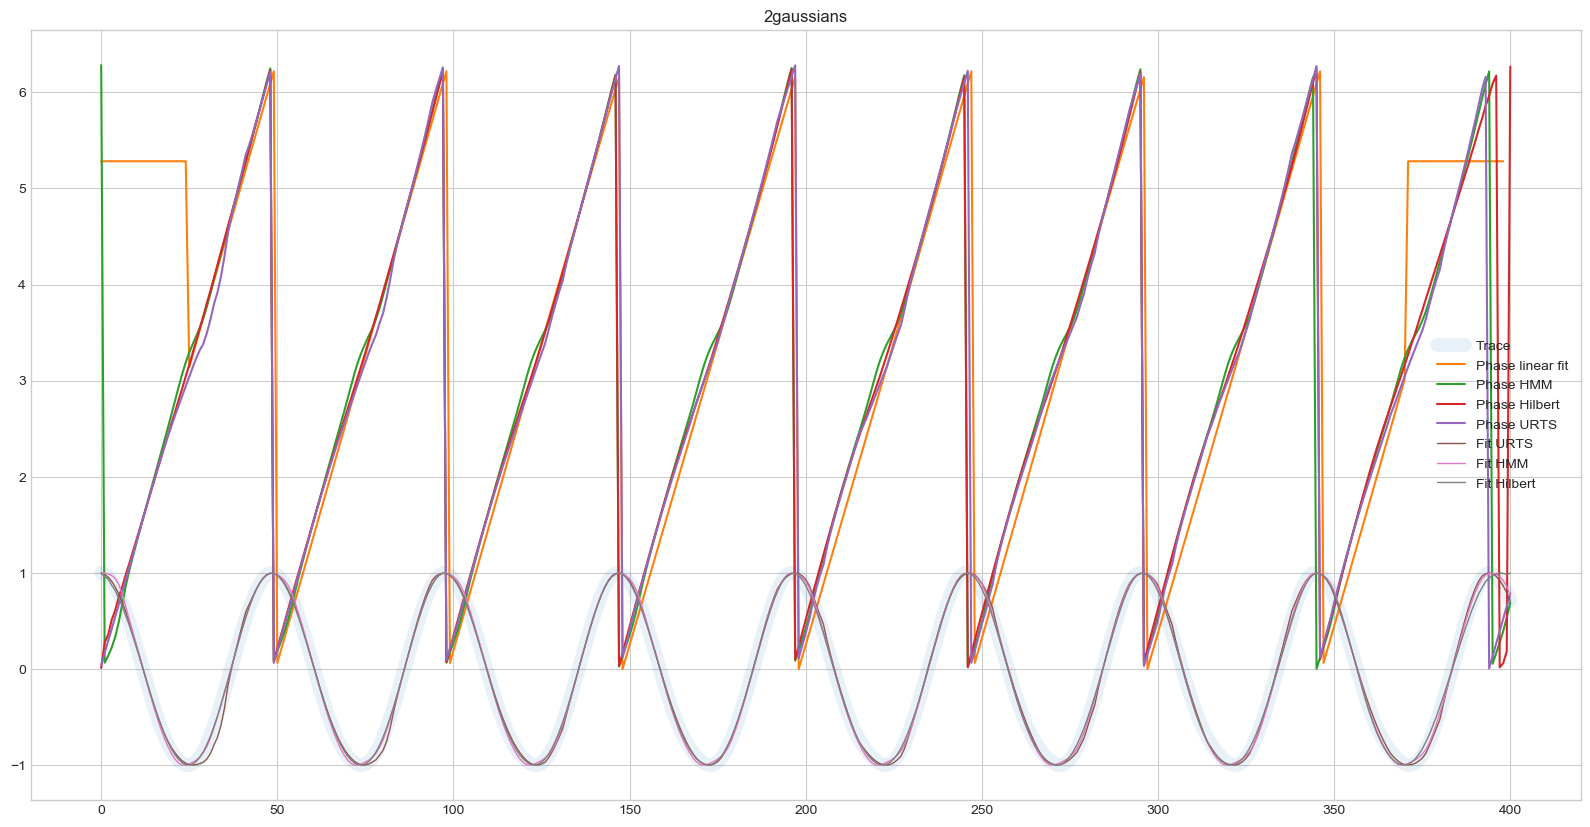

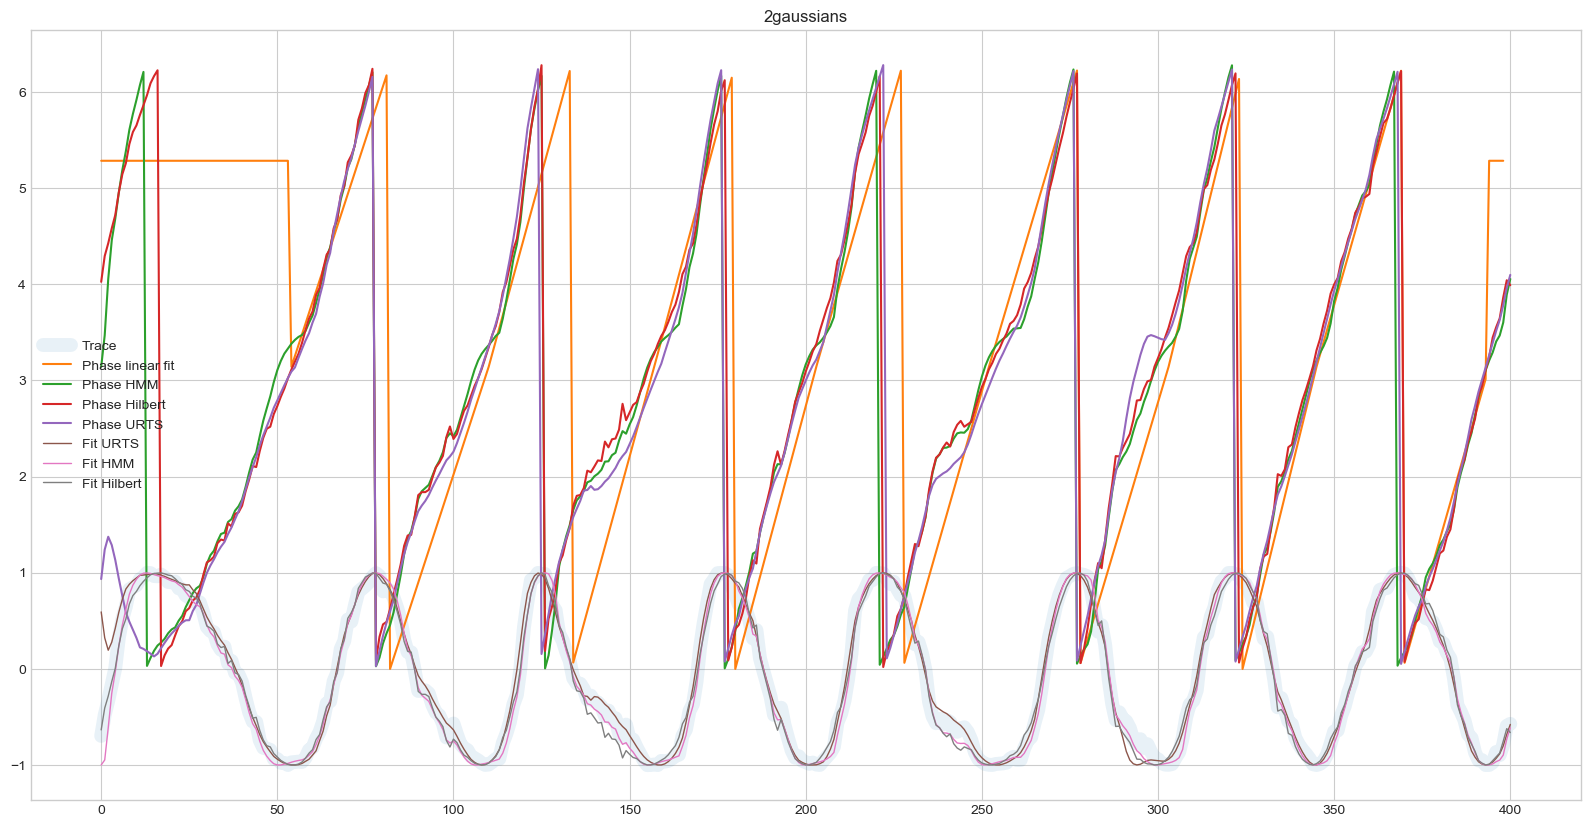

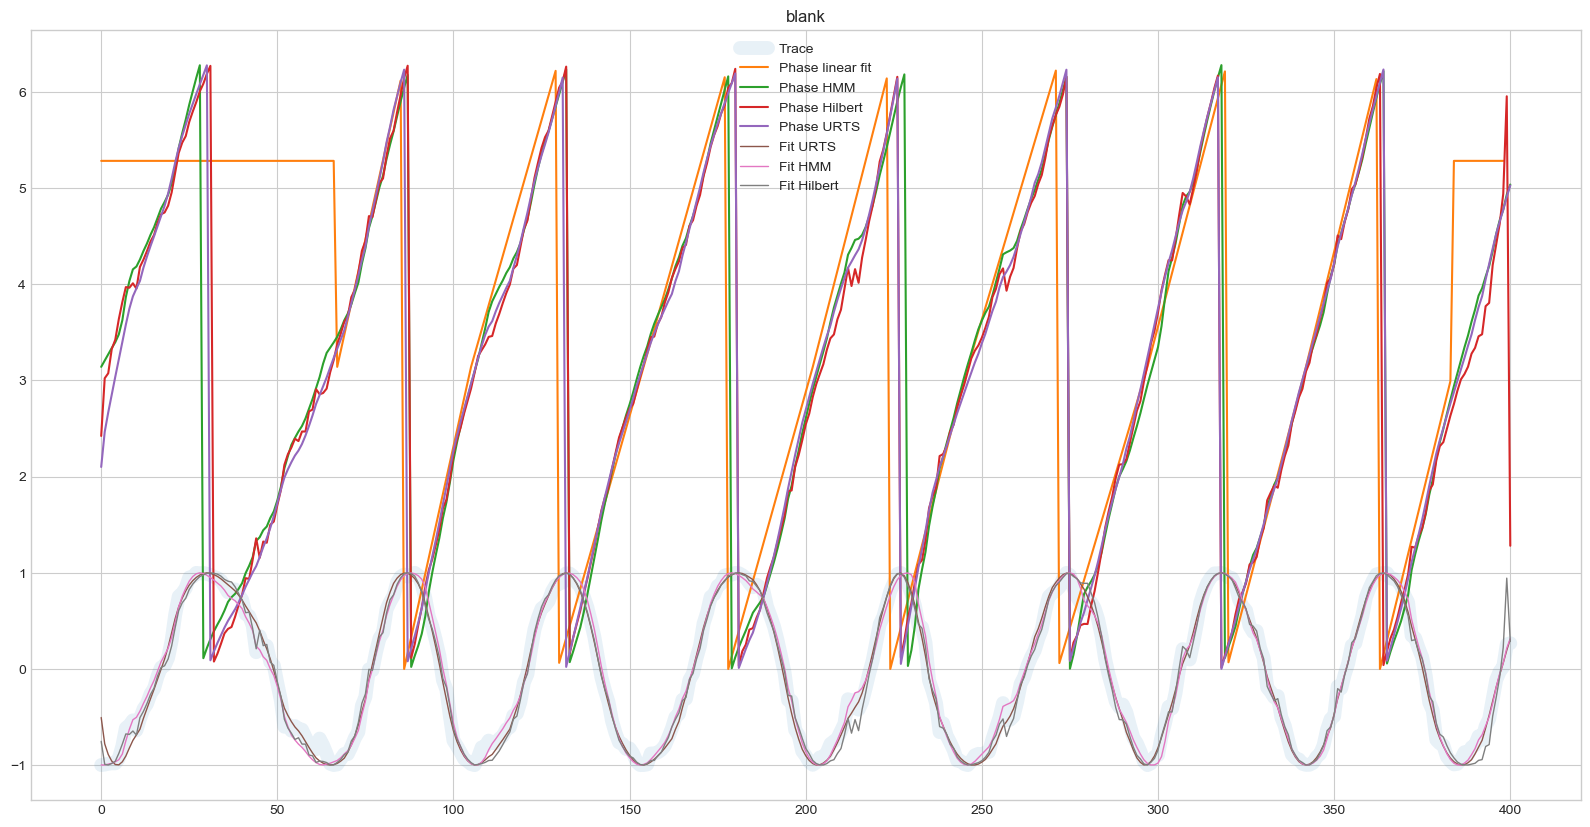

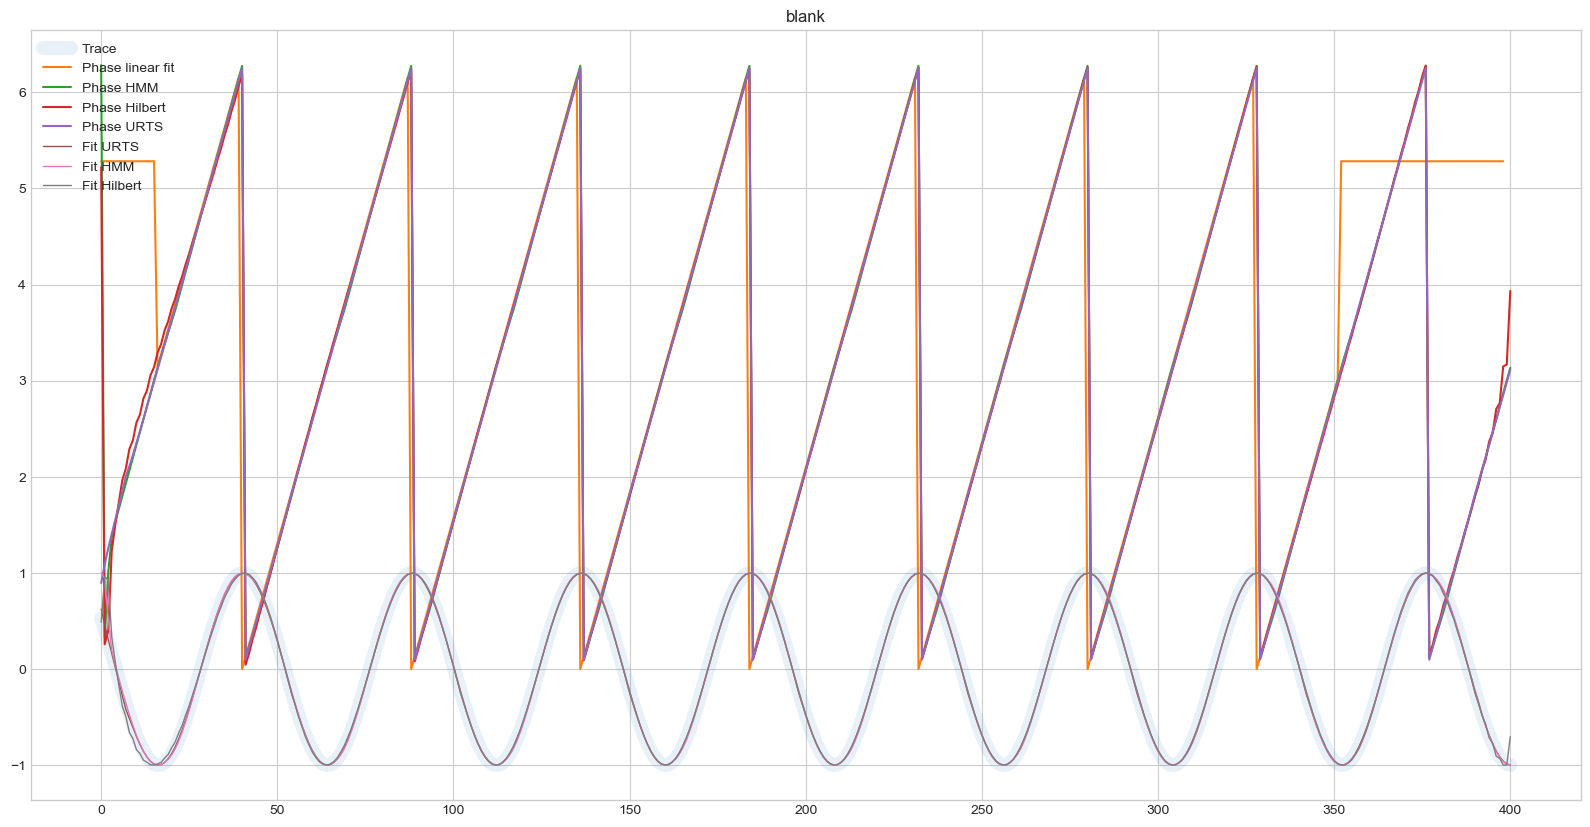

500


In [10]:
for (l_param, (l_traces, l_param_inf)) in d_all
    (Theta, Phi) = d_var[l_param]
    
    
    ll_phases_HMM = compute_HMM_all_traces(l_traces, Theta, Phi)
    ll_phases_linear_interpolation = compute_phase_linear_interpolation_all_traces(l_traces)
    ll_phases_hilbert = compute_phase_hilbert_all_traces(l_traces)
    ll_phases_URTS = compute_phase_URTS_all_traces(l_traces, Theta, Phi, 0.01, 1., 0.)
    
    
    
    figure(figsize = (20,10))
    title(l_param[3])
    plot(l_traces[1][:,3], lw = 10, alpha = 0.1, label = "Trace")
    plot(ll_phases_linear_interpolation[1][:,1], label = "Phase linear fit")
    plot(ll_phases_HMM[1][:,1], label = "Phase HMM")
    plot(ll_phases_hilbert[1][:,1], label = "Phase Hilbert")
    plot(ll_phases_URTS[1][:,1], label = "Phase URTS")
    
    
    plot(ω_fast(Theta,ll_phases_URTS[1][:,1]), lw = 1, label = "Fit URTS")
    plot(ω_fast(Theta,ll_phases_HMM[1][:,1]), lw = 1, label = "Fit HMM")
    plot(ω_fast(Theta,ll_phases_hilbert[1][:,1]), lw = 1, label = "Fit Hilbert")
    
    legend()
    show()
    
    """
    figure(figsize = (20,10))
    title(l_param[3])
    plot(l_traces[1][:,4], label = "Trace")
    plot(ll_phases_HMM[1][:,2], label = "Phase HMM")
    plot(ω_fast(Theta,ll_phases_HMM[1][:,2]), label = "Fit HMM")
    legend()
    show()
    """
    
    
    #record fits
    (name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2)= l_param
    cur_name = name_ω_θ*"_"*name_ω_ϕ*"_"*name_F_θ*"_"*name_F_ϕ*"_"*string(σ_ϕ1)*"_"*string(σ_ϕ2)*"_"*string(σₑ1)*
                       "_"*string(σₑ2)*"_"*string(μₐ1)*"_"*string(γₐ1)*"_"*string(σₐ1)*"_"*string(μᵦ1)*"_"*string(γᵦ1)*
                       "_"*string(σᵦ1)*"_"*string(μₐ2)*"_"*string(γₐ2)*"_"*string(σₐ2)*"_"*string(μᵦ2)*"_"*string(γᵦ2)*
                       "_"*string(σᵦ2) 
    
    
    path_fit = "Data/"*cur_name*"/Fits/"
    
    for (idx, l_phase) in enumerate(ll_phases_HMM)
        l_fit = hcat(l_phase, ω_fast(Theta,l_phase[:,1]), ω_fast(Phi,l_phase[:,2])  )
        writedlm(path_fit*"HMM_"*string(idx)*".txt", l_fit)
    end
    
    for (idx, l_phase) in enumerate(ll_phases_URTS)
        l_fit = hcat(l_phase, ω_fast(Theta,l_phase[:,1]), ω_fast(Phi,l_phase[:,2])  )
        writedlm(path_fit*"URTS_"*string(idx)*".txt", l_fit)
    end
    
    for (idx, l_phase) in enumerate(ll_phases_hilbert)
        l_fit = hcat(l_phase, ω_fast(Theta,l_phase[:,1]), ω_fast(Phi,l_phase[:,2])  )
        writedlm(path_fit*"hilbert_"*string(idx)*".txt", l_fit)
    end
            
        
    
    
    
      
end
            
        
        